# <h1 style="text-align:center;"> Introduction </h1>
The purpose of this model is to use the dataset of S&P500 stocks with their financial metrics, ratios and macroeconomic indicators to predict the yearly stock return. First let's set some ground rules for the type of predictions we will be doing.
* The yearly stock return is defined as
$$ \text{Stock Return} = \frac{\text{End of Year Price} - \text{Beginning of Year Price}}{\text{Beginning of Year Price}}*100 $$
* We will build a classification model for a binary target, which quantifies if the yearly stock return is over a certain threshold
$$
Target=
\begin{cases}
1 \text{ if } \text{Stock Return } >= THRESHOLD \\
0 \text{ if } \text{Stock Return } < THRESHOLD\\
\end{cases}
$$



In [268]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import optuna
import warnings
warnings.filterwarnings('ignore')

# <h1 style="text-align:center;">  Extracting Dataset </h1>

In [307]:
df = pd.read_csv('data/sp500_quarterly_data.csv', index_col=0)
df.index.name = 'Date'
df_macros = pd.read_csv('data/sp500_macro_quarterly_data.csv', index_col=0)
df_macros.index.name = 'Date'
df.sort_index(inplace=True)
df = df.set_index(['Ticker'], append=True)
df.tail(5)

pe-ratio  price-sales  price-book  price-fcf   
Date       Ticker                                                 
2023-05-19 CMI        12.21         1.02        2.89      23.94  \
           ITW        22.83         4.41       22.35      30.41   
           RL         14.55         1.19        2.92      76.56   
           CVS        22.97         0.28         NaN       5.23   
           ZTS          NaN          NaN       18.49      57.59   

                   current-ratio  quick-ratio  debt-equity-ratio  roe  roa   
Date       Ticker                                                            
2023-05-19 CMI               NaN          NaN                NaN  NaN  NaN  \
           ITW               NaN          NaN                NaN  NaN  NaN   
           RL                NaN          NaN                NaN  NaN  NaN   
           CVS               NaN          NaN                NaN  NaN  NaN   
           ZTS               NaN          NaN                NaN  NaN  NaN   

                   return-on-tangible-equity  ...  operating-income_Q   
Date       Ticker                             ...                       
2023-05-19 CMI                           NaN  ...                 NaN  \
           ITW                           NaN  ...                 NaN   
           RL                            NaN  ...                 NaN   
           CVS                           NaN  ...                 NaN   
           ZTS                           NaN  ...                 NaN   

                   operating-income_YoY  gross-profit_TTM  gross-profit_Q   
Date       Ticker                                                           
2023-05-19 CMI                      NaN               NaN             NaN  \
           ITW                      NaN               NaN             NaN   
           RL                       NaN               NaN             NaN   
           CVS                      NaN               NaN             NaN   
           ZTS                      NaN               NaN             NaN   

                   gross-profit_YoY  revenue_TTM  revenue_Q  revenue_YoY   
Date       Ticker                                                          
2023-05-19 CMI                  NaN          NaN        NaN          NaN  \
           ITW                  NaN          NaN        NaN          NaN   
           RL                   NaN          NaN        NaN          NaN   
           CVS                  NaN          NaN        NaN          NaN   
           ZTS                  NaN          NaN        NaN          NaN   

                   Adj Close  Yearly Change (%)  
Date       Ticker                                
2023-05-19 CMI           NaN                NaN  
           ITW           NaN                NaN  
           RL            NaN                NaN  
           CVS           NaN                NaN  
           ZTS           NaN                NaN  

[5 rows x 41 columns]

In [308]:
THRESHOLD = 12.5

def _target(x):
    if x >= THRESHOLD:
        return 1
    else:
        return 0

In [309]:
df.dropna(subset=['Yearly Change (%)'], inplace=True)
df['Target'] = df['Yearly Change (%)'].apply(_target)
df.fillna(0,inplace=True)
df_macros.dropna(subset=['Yearly Change (%)'], inplace=True)
df_macros['Target'] = df_macros['Yearly Change (%)'].apply(_target)
df_macros.fillna(0,inplace=True)

# <h1 style="text-align:center;"> Models </h1>

In [310]:
models = [
    ('kNN', KNeighborsClassifier()),
    ('xgb', XGBClassifier()),
    ('rf', RandomForestClassifier(n_estimators=250, max_depth=10)),
    ('lgbm', lgb.LGBMClassifier()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100,50))),
]

In [273]:
def score_models():
    X = df_macros.drop(['Target', 'Yearly Change (%)', 'Ticker'], axis=1)
    y = df_macros['Target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345, shuffle=False)
    for model_name, model in models:
        model.fit(X_train,y_train)
        print(f"================= {model_name} Results =================")
        print(f"Train Accuracy: {accuracy_score(model.predict(X_train), y_train)}")
        print(f"Test Accuracy: {accuracy_score(model.predict(X_test), y_test)}")

In [274]:
def score_models_without_macros():
    X = df.drop(['Target', 'Yearly Change (%)'], axis=1)
    y = df['Target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345, shuffle=False)
    for model_name, model in models:
        model.fit(X_train,y_train)
        print(f"================= {model_name} Results =================")
        print(f"Train Accuracy: {accuracy_score(model.predict(X_train), y_train)}")
        print(f"Test Accuracy: {accuracy_score(model.predict(X_test), y_test)}")

In [153]:
score_models()

================= kNN Results =================
Train Accuracy: 0.7608546918583232
Test Accuracy: 0.5
================= xgb Results =================
Train Accuracy: 0.9260565233408768
Test Accuracy: 0.5045784654246921
================= rf Results =================
Train Accuracy: 0.8291668859533708
Test Accuracy: 0.45389958951689297
================= lgbm Results =================
Train Accuracy: 0.8191147834324509
Test Accuracy: 0.48168613830123147
================= mlp Results =================
Train Accuracy: 0.6266512288826904
Test Accuracy: 0.5350489422166088


In [154]:
score_models_without_macros()

================= kNN Results =================
Train Accuracy: 0.7619072680385243
Test Accuracy: 0.5396274076413009
================= xgb Results =================
Train Accuracy: 0.8972685648123783
Test Accuracy: 0.5873065993053362
================= rf Results =================
Train Accuracy: 0.8341139940003158
Test Accuracy: 0.6040416798231765
================= lgbm Results =================
Train Accuracy: 0.802063049313194
Test Accuracy: 0.5994632143984844
================= mlp Results =================
Train Accuracy: 0.6089153202463028
Test Accuracy: 0.5779917903378592


<h1 style="text-align:center;"> Correlation </h1>

In [155]:
corr = X.corr().abs()

In [156]:
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,pe-ratio,price-sales,price-book,price-fcf,current-ratio,quick-ratio,debt-equity-ratio,roe,roa,return-on-tangible-equity,ebitda-margin,total-assets_Q,total-assets_YoY,total-liabilities_Q,total-liabilities_YoY,total-share-holder-equity_Q,total-share-holder-equity_YoY,long-term-debt_Q,long-term-debt_YoY,shares-outstanding_Q,shares-outstanding_YoY,eps-earnings-per-share-diluted_TTM,eps-earnings-per-share-diluted_Q,eps-earnings-per-share-diluted_YoY,net-income_TTM,net-income_Q,net-income_YoY,ebitda_TTM,ebitda_Q,ebitda_YoY,operating-income_TTM,operating-income_Q,operating-income_YoY,gross-profit_TTM,gross-profit_Q,gross-profit_YoY,revenue_TTM,revenue_Q,revenue_YoY,Adj Close,growth-rate,unemployment-rate,inflation-rate,interest-rates
pe-ratio,1.00,0.09,0.01,0.02,0.01,0.02,0.00,0.00,0.02,0.00,0.01,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.00,0.00,0.01,0.02,0.00,0.03,0.02,0.00,0.02,0.01,0.02,0.03,0.02,0.01,0.02,0.02,0.03,0.02,0.02,0.04,0.05,0.03,0.04,0.01,0.04
price-sales,0.09,1.00,0.04,0.05,0.11,0.06,0.00,0.00,0.04,0.00,0.57,0.05,0.05,0.05,0.05,0.03,0.03,0.05,0.05,0.01,0.01,0.00,0.00,0.03,0.00,0.00,0.03,0.02,0.01,0.04,0.02,0.01,0.03,0.06,0.05,0.08,0.11,0.11,0.10,0.15,0.09,0.08,0.02,0.05
price-book,0.01,0.04,1.00,0.02,0.00,0.01,0.70,0.07,0.05,0.00,0.00,0.02,0.02,0.02,0.02,0.03,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.04,0.02,0.03,0.01,0.01
price-fcf,0.02,0.05,0.02,1.00,0.01,0.01,0.00,0.01,0.00,0.00,0.01,0.01,0.01,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.00,0.01,0.01,0.01,0.01,0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.04,0.03,0.03,0.01,0.02
current-ratio,0.01,0.11,0.00,0.01,1.00,0.33,0.00,0.00,0.09,0.00,0.01,0.08,0.08,0.08,0.08,0.06,0.06,0.07,0.07,0.01,0.01,0.00,0.01,0.00,0.03,0.02,0.01,0.04,0.03,0.03,0.04,0.03,0.02,0.07,0.07,0.03,0.08,0.08,0.04,0.02,0.01,0.01,0.00,0.00
quick-ratio,0.02,0.06,0.01,0.01,0.33,1.00,0.01,0.00,0.13,0.00,0.01,0.13,0.13,0.14,0.14,0.07,0.07,0.10,0.10,0.07,0.07,0.01,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.05,0.01,0.01,0.03,0.07,0.07,0.05,0.07,0.06,0.05,0.01,0.01,0.06,0.01,0.05
debt-equity-ratio,0.00,0.00,0.70,0.00,0.00,0.01,1.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.01
roe,0.00,0.00,0.07,0.01,0.00,0.00,0.01,1.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.01,0.01,0.01,0.01
roa,0.02,0.04,0.05,0.00,0.09,0.13,0.01,0.02,1.00,0.01,0.19,0.11,0.11,0.11,0.11,0.06,0.05,0.11,0.11,0.10,0.10,0.17,0.23,0.10,0.23,0.19,0.08,0.14,0.12,0.07,0.17,0.15,0.06,0.04,0.05,0.03,0.02,0.02,0.03,0.19,0.10,0.01,0.03,0.05
return-on-tangible-equity,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,1.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#  <h1 style="text-align:center;">💡 Insights </h1>

* The quarterly and trailing twelve months features are highly correlated for most of the features that include both of them, so one of them could be removed in some cases, in this case, we will take out the Quarterly ones, since trailing twelve month features should better encapsulate tendency, and focus less on seasonality.
* Operating income and net income have a correlation of 95%, so it might be benefitial to drop one of them.
* Assets and liabilities are highly correlated.

In [311]:
def _DelCorrelatedVariables(X):

    # Find features with correlation greater than 0.95
    to_drop = ['revenue_Q',
                'gross-profit_Q',
                'operating-income_TTM',
                'total-assets_Q',
                'total-liabilities_Q',
                'total-liabilities_YoY',
                'net-income_YoY',
                'total-share-holder-equity_Q',
                'long-term-debt_Q',
                'shares-outstanding_Q'
                ]

    # Drop features 
    return X.drop(to_drop, axis=1)

In [312]:
def FeatureEngineering(df):
    X = df.copy(deep=True)
    X['revenue_TTM_change'] = X.groupby(level='Ticker').revenue_TTM.diff()
    X['pe-ratio-change'] = X.groupby(level='Ticker')['pe-ratio'].diff()
    X['price-sales-change'] = X.groupby(level='Ticker')['price-sales'].diff()
    X['price-fcf-change'] = X.groupby(level='Ticker')['price-fcf'].diff()
    X['total-assets_YoY_change'] = X.groupby(level='Ticker')['total-assets_YoY'].diff()
    X.fillna(0, inplace=True)
    return X

In [313]:
FeatureEngineering(df).columns

Index(['pe-ratio', 'price-sales', 'price-book', 'price-fcf', 'current-ratio',
       'quick-ratio', 'debt-equity-ratio', 'roe', 'roa',
       'return-on-tangible-equity', 'ebitda-margin', 'total-assets_Q',
       'total-assets_YoY', 'total-liabilities_Q', 'total-liabilities_YoY',
       'total-share-holder-equity_Q', 'total-share-holder-equity_YoY',
       'long-term-debt_Q', 'long-term-debt_YoY', 'shares-outstanding_Q',
       'shares-outstanding_YoY', 'eps-earnings-per-share-diluted_TTM',
       'eps-earnings-per-share-diluted_Q',
       'eps-earnings-per-share-diluted_YoY', 'net-income_TTM', 'net-income_Q',
       'net-income_YoY', 'ebitda_TTM', 'ebitda_Q', 'ebitda_YoY',
       'operating-income_TTM', 'operating-income_Q', 'operating-income_YoY',
       'gross-profit_TTM', 'gross-profit_Q', 'gross-profit_YoY', 'revenue_TTM',
       'revenue_Q', 'revenue_YoY', 'Adj Close', 'Yearly Change (%)', 'Target',
       'revenue_TTM_change', 'pe-ratio-change', 'price-sales-change',
       'pri

In [314]:
def pipeline_score(df):
    X = df.drop(['Target', 'Yearly Change (%)'], axis=1)
    X = _DelCorrelatedVariables(X)
    X = FeatureEngineering(X)
    y = df['Target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345, shuffle=False)
    for model_name, model in models:
        model.fit(X_train,y_train)
        print(f"================= {model_name} Results =================")
        print(f"Train Accuracy: {accuracy_score(model.predict(X_train), y_train)}")
        print(f"Test Accuracy: {accuracy_score(model.predict(X_test), y_test)}")
        print(f"Train Precision: {precision_score(model.predict(X_train), y_train)}")
        print(f"Test Precision: {precision_score(model.predict(X_test), y_test)}")

In [315]:
pipeline_score(df)

================= kNN Results =================
Train Accuracy: 0.751486763854534
Test Accuracy: 0.5067887590779918
Train Precision: 0.8290598290598291
Test Precision: 0.5333103210217466
================= xgb Results =================
Train Accuracy: 0.9147939582127257
Test Accuracy: 0.5569940006315125
Train Precision: 0.9631751227495908
Test Precision: 0.5322747670003452
================= rf Results =================
Train Accuracy: 0.8319035840218936
Test Accuracy: 0.5672560783075465
Train Precision: 0.9628114202582287
Test Precision: 0.5819813600276148
================= lgbm Results =================
Train Accuracy: 0.8054312930898374
Test Accuracy: 0.5685191032522893
Train Precision: 0.9173486088379705
Test Precision: 0.5502243700379703
================= mlp Results =================
Train Accuracy: 0.6422293563496658
Test Accuracy: 0.5080517840227344
Train Precision: 0.8634297144935443
Test Precision: 0.5698998964445978


In [279]:
def _retrieve_best_model(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])

In [319]:
X = df.drop(['Target', 'Yearly Change (%)'], axis=1)
X = _DelCorrelatedVariables(X)
X = FeatureEngineering(X)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345, shuffle=False)

def objective_lgbm(trial):

    
    #Instantiate parameters for the model    
    model = lgb.LGBMClassifier(random_state = 1234,
                              reg_alpha= trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
                              reg_lambda= trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
                              num_leaves= trial.suggest_int('num_leaves', 2, 256),
                              colsample_bytree= trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
                              subsample= trial.suggest_uniform('subsample', 0.4, 1.0),
                              subsample_freq= trial.suggest_int('subsample_freq', 1, 7),
                              min_child_samples= trial.suggest_int('min_child_samples', 5, 100)
                             )

    trial.set_user_attr(key="best_booster", value=model)
    
    #Create Folds to evaluate models using cross validation
    model.fit(X_train,y_train, eval_metric='accuracy')
    return accuracy_score(model.predict(X_test), y_test)

In [320]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lgbm = optuna.create_study(direction="maximize")
study_lgbm.optimize(objective_lgbm, n_trials=300, callbacks=[_retrieve_best_model])

print(study_lgbm.best_trial)

FrozenTrial(number=164, state=TrialState.COMPLETE, values=[0.5787811809283233], datetime_start=datetime.datetime(2023, 5, 30, 19, 24, 5, 672938), datetime_complete=datetime.datetime(2023, 5, 30, 19, 24, 6, 89855), params={'lambda_l1': 0.006382816650308997, 'reg_lambda': 0.005019298740528287, 'num_leaves': 39, 'colsample_bytree': 0.4800999051616117, 'subsample': 0.9082196270895194, 'subsample_freq': 1, 'min_child_samples': 53}, user_attrs={'best_booster': LGBMClassifier(colsample_bytree=0.4800999051616117, min_child_samples=53,
               num_leaves=39, random_state=1234, reg_alpha=0.006382816650308997,
               reg_lambda=0.005019298740528287, subsample=0.9082196270895194,
               subsample_freq=1)}, system_attrs={}, intermediate_values={}, distributions={'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'reg_lambda': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1),

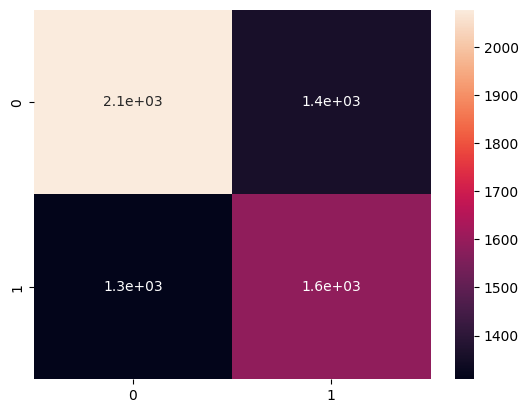

In [321]:
best_lgbm = study_lgbm.user_attrs["best_booster"]
cm = confusion_matrix(y_test, best_lgbm.predict(X_test))
s = sns.heatmap(cm, annot=True)

# <h1 style="text-align:center;">  Backtesting Strategy </h1>
The models presented above, and for which we carried out a specific hyperparameter tuning will be tested now on historical data, with a very simple investment strategy, to determine the historical returns they would have generated. The strategy is as follows:
* If we predict the price of the stock will rise more than the THRESHOLD then we buy the stock.
* We hold the stock for 1 year and sell.

In [328]:
_, backtest_df= train_test_split(df, test_size=0.25, random_state=12345, shuffle=False)

In [329]:
backtest_df['Predicted'] =  best_lgbm.predict(X_test)

In [330]:
backtest_df

pe-ratio  price-sales  price-book  price-fcf   
Date       Ticker                                                 
2019-03-31 CMS        22.31         2.00        2.86       0.00  \
           IDXX       50.59         8.76      370.94      73.44   
           DVA        64.63         0.82        2.21      12.50   
           TSN        13.13         0.58        1.70       0.00   
           CB         15.34         1.84        1.13       9.64   
...                     ...          ...         ...        ...   
2022-06-30 LUV        22.62         1.04        1.91      27.20   
           ALGN       30.30         4.70        5.13      48.55   
           AXP        14.02         2.13        4.43       6.81   
           LIN        41.44         4.51        3.48      21.46   
           ENPH      136.53        16.11       58.63      60.13   

                   current-ratio  quick-ratio  debt-equity-ratio        roe   
Date       Ticker                                                             
2019-03-31 CMS             1.128        0.918              2.287      13.12  \
           IDXX            1.012        0.737             13.482  156400.00   
           DVA             1.121        1.108              1.416       3.13   
           TSN             1.382        0.537              0.797      15.37   
           CB              0.264        0.000              0.231       7.66   
...                          ...          ...                ...        ...   
2022-06-30 LUV             1.656        1.592              0.798       9.43   
           ALGN            1.317        1.145              0.000      17.19   
           AXP             1.627        0.000              1.743      32.38   
           LIN             0.737        0.620              0.272       8.05   
           ENPH            3.617        3.345              2.656      43.87   

                     roa  return-on-tangible-equity  ...  gross-profit_TTM   
Date       Ticker                                    ...                     
2019-03-31 CMS      2.61                      13.12  ...             3.893  \
           IDXX    24.89                    -155.78  ...             1.270   
           DVA      0.64                      -4.71  ...             3.174   
           TSN      6.53                     -47.55  ...             5.185   
           CB       2.33                      13.23  ...             8.152   
...                  ...                        ...  ...               ...   
2022-06-30 LUV      2.67                      10.39  ...             6.096   
           ALGN    10.61                      20.07  ...             2.897   
           AXP      3.86                      32.38  ...            48.203   
           LIN      4.35                      89.62  ...            13.601   
           ENPH     9.06                      92.31  ...             0.699   

                   gross-profit_Q  gross-profit_YoY  revenue_TTM  revenue_Q   
Date       Ticker                                                             
2019-03-31 CMS              1.117              7.51        6.979      2.059  \
           IDXX             0.332              9.57        2.251      0.576   
           DVA              0.778             -4.42       11.298      2.743   
           TSN              1.192             17.44       40.686     10.443   
           CB               2.118              0.19       32.762      7.876   
...                           ...               ...          ...        ...   
2022-06-30 LUV              2.274             52.11       21.152      6.728   
           ALGN             0.688             -9.35        3.990      0.970   
           AXP             13.395             30.77       49.562     13.834   
           LIN              3.517              3.75       32.634      8.457   
           ENPH             0.219             71.09        1.736      0.530   

                   revenue_YoY   Adj Close  Yearly Change (%)  Target   
Dat

In [335]:
backtest_df['Invested'] = np.where(backtest_df['Predicted']==1, backtest_df['Adj Close'], 0.0)
backtest_df['Return'] = np.where(backtest_df['Predicted']==1, backtest_df['Adj Close']*(1+backtest_df['Yearly Change (%)']/100)-backtest_df['Adj Close'], 0.0)

In [336]:
backtest_df

pe-ratio  price-sales  price-book  price-fcf   
Date       Ticker                                                 
2019-03-31 CMS        22.31         2.00        2.86       0.00  \
           IDXX       50.59         8.76      370.94      73.44   
           DVA        64.63         0.82        2.21      12.50   
           TSN        13.13         0.58        1.70       0.00   
           CB         15.34         1.84        1.13       9.64   
...                     ...          ...         ...        ...   
2022-06-30 LUV        22.62         1.04        1.91      27.20   
           ALGN       30.30         4.70        5.13      48.55   
           AXP        14.02         2.13        4.43       6.81   
           LIN        41.44         4.51        3.48      21.46   
           ENPH      136.53        16.11       58.63      60.13   

                   current-ratio  quick-ratio  debt-equity-ratio        roe   
Date       Ticker                                                             
2019-03-31 CMS             1.128        0.918              2.287      13.12  \
           IDXX            1.012        0.737             13.482  156400.00   
           DVA             1.121        1.108              1.416       3.13   
           TSN             1.382        0.537              0.797      15.37   
           CB              0.264        0.000              0.231       7.66   
...                          ...          ...                ...        ...   
2022-06-30 LUV             1.656        1.592              0.798       9.43   
           ALGN            1.317        1.145              0.000      17.19   
           AXP             1.627        0.000              1.743      32.38   
           LIN             0.737        0.620              0.272       8.05   
           ENPH            3.617        3.345              2.656      43.87   

                     roa  return-on-tangible-equity  ...  gross-profit_YoY   
Date       Ticker                                    ...                     
2019-03-31 CMS      2.61                      13.12  ...              7.51  \
           IDXX    24.89                    -155.78  ...              9.57   
           DVA      0.64                      -4.71  ...             -4.42   
           TSN      6.53                     -47.55  ...             17.44   
           CB       2.33                      13.23  ...              0.19   
...                  ...                        ...  ...               ...   
2022-06-30 LUV      2.67                      10.39  ...             52.11   
           ALGN    10.61                      20.07  ...             -9.35   
           AXP      3.86                      32.38  ...             30.77   
           LIN      4.35                      89.62  ...              3.75   
           ENPH     9.06                      92.31  ...             71.09   

                   revenue_TTM  revenue_Q  revenue_YoY   Adj Close   
Date       Ticker                                                    
2019-03-31 CMS           6.979      2.059         5.43   49.293716  \
           IDXX          2.251      0.576         7.06  223.600006   
           DVA          11.298      2.743        -3.72   54.290001   
           TSN          40.686     10.443         6.86   63.161873   
           CB           32.762      7.876         0.57  129.540604   
...                        ...        ...          ...         ...   
2022-06-30 LUV          21.152      6.728        67.86   35.743069   
           ALGN          3.990      0.970        -4.06  236.669998   
           AXP          49.562     13.834        30.94  137.107910   
           LIN          32.634      8.457        11.51  284.279816   
           ENPH          1.736      0.530        67.72  195.240005   

                   Yearly Change (%)  Target  Predicted    Invested     Return  
Date       Ticker                                                               
2019-03-31 CMS              8.5

The result of the backtesting strategy for the tuned LGBM Classificator between 2019-03-31 and 2022-06-30 is

In [343]:
print(f"{backtest_df['Return'].sum()/backtest_df['Invested'].sum()*100}%")

17.4782460878074%


# <h1 style="text-align:center;">  Result </h1>
We managed to create a strategy that returns around 17% for a period just over 3 years, which is just shy of a 6% annualized return. Please note that this strategy hasn't been thoroughly backtested, and is just a quick and simple example of usage of the dataset. However a series of improvements and further work can be organized around it, especially in the following areas:
* Further improve the feature engineering to include different tendency metrics, such as rolling means, which might encapsulate the tendency of a stock.
* Improve the overall backtesting strategy, including a bigger timeframe, different stocks, custom portfolio weight strategy, etc.
* We can create a metric function based on the returns of a through and diversified backtesting strategy to train the model upon, so it maximizes the return on these cases. The idea behind it is, that if the backtesting strategy is general and widespread enough then doing so will create more robust models.